In [1]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.metaestimators import _BaseComposition
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.all_model import AllModel, AllModelData
from server.ml_models.sklearn import AveragingRegressor
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance
from server.ml_models.data_config import TEAM_NAMES, ROUND_TYPES


SEED = 42
N_ITER = 5
CV = 5

np.random.seed(SEED)

## Compare averaging, stacking, and bagging

In [2]:
# Take top-performing models from all data notebook (6.2-all-data-nn)

PIPELINE_STEPS = [
    ColumnTransformer(
        [
            (
                "onehotencoder",
                OneHotEncoder(
                    categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES], sparse=False
                ),
                slice(0, 3),
            )
        ],
        remainder=StandardScaler(),
    ),
]
ESTIMATORS = [
    ('ridge', Ridge()),
    ('gradientboostingregressor', GradientBoostingRegressor()),
    ('linearsvr', LinearSVR()),
    ('xgbregressor', XGBRegressor()),
]

models = []
data = AllModelData(train_years=(None, 2015), test_years=(2016, 2016))
features, labels = data.train_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)

for name, estimator in ESTIMATORS:
    model = AllModel(pipeline=make_pipeline(*PIPELINE_STEPS, estimator), name=name)
    models.append((name, model))

all_model = AllModel(pipeline=make_pipeline(*PIPELINE_STEPS, XGBRegressor()))
bag_model = BaggingRegressor(base_estimator=all_model)
avg_model = AveragingRegressor(models)
stack_model = make_pipeline(
    *PIPELINE_STEPS,
    StackingRegressor(regressors=[estimator for _, estimator in ESTIMATORS],
                      meta_regressor=XGBRegressor())
)

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### All data with XGB

In [3]:
all_params = {
    'pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

all_cv = RandomizedSearchCV(all_model, all_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=CV,
                            n_iter=N_ITER, random_state=SEED)

In [4]:
all_cv.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=AllModel(name='AllModel',
     pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Ade...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__xgbregressor__colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f095bbc2e48>, 'pipeline__xgbregressor__colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen o

In [5]:
all_cv.best_score_, all_cv.best_params_

(-26.884101203982823,
 {'pipeline__xgbregressor__booster': 'dart',
  'pipeline__xgbregressor__colsample_bylevel': 0.8041168988591605,
  'pipeline__xgbregressor__colsample_bytree': 0.9939819704323989,
  'pipeline__xgbregressor__learning_rate': 0.11662213204002109,
  'pipeline__xgbregressor__max_depth': 7,
  'pipeline__xgbregressor__n_estimators': 76,
  'pipeline__xgbregressor__reg_alpha': 0.03636499344142013,
  'pipeline__xgbregressor__reg_lambda': 0.8417022549267169,
  'pipeline__xgbregressor__subsample': 0.8608484485919076})

### Bagging with XGB

In [6]:
bag_params = {
    'n_estimators': stats.randint(5, 15),
    'base_estimator__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'base_estimator__pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'base_estimator__pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'base_estimator__pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'base_estimator__pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'base_estimator__pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'base_estimator__pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'base_estimator__pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'base_estimator__pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

bag_cv = RandomizedSearchCV(bag_model, bag_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=CV,
                            n_iter=N_ITER, random_state=SEED)

In [7]:
bag_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BaggingRegressor(base_estimator=AllModel(name='AllModel',
     pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=Non...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f092b5f4dd8>, 'base_estimator__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'], 'base_estimator__pipeline__xgbregressor__colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen ob...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f092a2e57b8>},
          pre_dispatch='2*n_jobs', random_state=42, 

In [8]:
bag_cv.best_score_, bag_cv.best_params_

(-26.53126897356673,
 {'base_estimator__pipeline__xgbregressor__booster': 'gbtree',
  'base_estimator__pipeline__xgbregressor__colsample_bylevel': 0.8092900825439996,
  'base_estimator__pipeline__xgbregressor__colsample_bytree': 0.9215089703802877,
  'base_estimator__pipeline__xgbregressor__learning_rate': 0.08352620618436457,
  'base_estimator__pipeline__xgbregressor__max_depth': 8,
  'base_estimator__pipeline__xgbregressor__n_estimators': 92,
  'base_estimator__pipeline__xgbregressor__reg_alpha': 0.18977710745066667,
  'base_estimator__pipeline__xgbregressor__reg_lambda': 1.2328160165372797,
  'base_estimator__pipeline__xgbregressor__subsample': 0.9616794696232923,
  'n_estimators': 13})

### Stacked with XGB

In [9]:
stack_params = {
    'stackingregressor__ridge__alpha': stats.uniform(0.75, 0.5),
    'stackingregressor__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'stackingregressor__gradientboostingregressor__alpha': stats.uniform(0.7, 0.3),
    'stackingregressor__gradientboostingregressor__learning_rate': stats.uniform(0.075, 0.05),
    'stackingregressor__gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'stackingregressor__gradientboostingregressor__max_depth': stats.randint(2, 10),
    'stackingregressor__gradientboostingregressor__max_features': stats.uniform(0.8, 0.2),
    'stackingregressor__gradientboostingregressor__max_leaf_nodes': [None, 2, 4, 6, 8, 10],
    'stackingregressor__gradientboostingregressor__min_samples_leaf': stats.randint(1, 5),
    'stackingregressor__gradientboostingregressor__min_samples_split': stats.randint(2, 6),
    'stackingregressor__gradientboostingregressor__n_estimators': stats.randint(75, 150),
    'stackingregressor__gradientboostingregressor__subsample': stats.uniform(0.8, 0.2),
    'stackingregressor__linearsvr__C': stats.uniform(0.75, 0.5),
    'stackingregressor__linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'stackingregressor__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'stackingregressor__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'stackingregressor__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'stackingregressor__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'stackingregressor__xgbregressor__max_depth': stats.randint(2, 10),
    'stackingregressor__xgbregressor__n_estimators': stats.randint(75, 150),
    'stackingregressor__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'stackingregressor__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'stackingregressor__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

stack_cv = RandomizedSearchCV(stack_model, stack_params, scoring='neg_mean_absolute_error', n_jobs=-1,
                              cv=CV, n_iter=N_ITER, random_state=SEED)

In [10]:
stack_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Ade...)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'stackingregressor__ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f095b4572b0>, 'stackingregressor__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'stackingregressor__gradientboostingregressor__alpha': <scipy.stats._di...r__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f095b43ee48>},
          pre_

In [11]:
stack_cv.best_score_, stack_cv.best_params_

(-26.71538797268626,
 {'stackingregressor__gradientboostingregressor__alpha': 0.7913841307520112,
  'stackingregressor__gradientboostingregressor__learning_rate': 0.07988360570031919,
  'stackingregressor__gradientboostingregressor__loss': 'quantile',
  'stackingregressor__gradientboostingregressor__max_depth': 5,
  'stackingregressor__gradientboostingregressor__max_features': 0.8880304987479203,
  'stackingregressor__gradientboostingregressor__max_leaf_nodes': 6,
  'stackingregressor__gradientboostingregressor__min_samples_leaf': 1,
  'stackingregressor__gradientboostingregressor__min_samples_split': 5,
  'stackingregressor__gradientboostingregressor__n_estimators': 121,
  'stackingregressor__gradientboostingregressor__subsample': 0.8346729307015545,
  'stackingregressor__linearsvr__C': 0.9455303037866204,
  'stackingregressor__linearsvr__loss': 'squared_epsilon_insensitive',
  'stackingregressor__ridge__alpha': 1.081261142176991,
  'stackingregressor__ridge__solver': 'svd',
  'stacki

### Averaging estimates

In [13]:
avg_params = {
    'weights': [stats.uniform(0.0, 1.0).rvs(size=4) for _ in range(N_ITER)],
    'ridge__pipeline__ridge__alpha': stats.uniform(0.75, 0.5),
    'ridge__pipeline__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': stats.uniform(0.7, 0.3),
    'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': stats.uniform(0.075, 0.05),
    'gradientboostingregressor__pipeline__gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': stats.randint(2, 10),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': stats.uniform(0.8, 0.2),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': [None, 2, 4, 6, 8, 10],
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': stats.randint(1, 5),
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': stats.randint(2, 6),
    'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': stats.randint(75, 150),
    'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': stats.uniform(0.8, 0.2),
    'linearsvr__pipeline__linearsvr__C': stats.uniform(0.75, 0.5),
    'linearsvr__pipeline__linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'xgbregressor__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'xgbregressor__pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'xgbregressor__pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'xgbregressor__pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'xgbregressor__pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'xgbregressor__pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'xgbregressor__pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

avg_cv = RandomizedSearchCV(avg_model, avg_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=CV,
                            n_iter=N_ITER, random_state=SEED)

In [14]:
avg_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=AveragingRegressor(estimators=[('ridge', AllModel(name='ridge',
     pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=None,
         transformer...    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])))],
          weights=None),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'weights': [array([0.34303, 0.45014, 0.40724, 0.82841]), array([0.01491, 0.80443, 0.64416, 0.93988]), array([0.68679, 0.47484, 0.26775, 0.72628]), array([0.65166, 0.69032, 0.13691, 0.77541]), array([0.18982, 0.84473, 0.52959, 0.75993])], 'ridge__pipeline__ridge__alpha': <scipy.s...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f093fc221d0>}

In [15]:
avg_cv.best_score_, avg_cv.best_params_

(-26.536707315065037,
 {'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': 0.7069187275124247,
  'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': 0.10123873301291945,
  'gradientboostingregressor__pipeline__gradientboostingregressor__loss': 'huber',
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': 3,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': 0.8093331326427231,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': 6,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': 4,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': 4,
  'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': 136,
  'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': 0.8181212869065642,
  'linearsvr__pipeline__linearsvr__C': 1.0591930046665436,
 

In [16]:
bag_cv.score(*data.test_data()), avg_cv.score(*data.test_data())

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

(-28.52425811299379, -28.20464914155341)

### Bagging XGB is about the same as averaging a few different models
They have almost identical CV scores, and averaging does slightly better on the validation set, but it's close enough, and the validation set is small enough, that it's basically a wash.

## Yearly comparison of bagging and averaging

In [17]:
avg_model.set_params(**avg_cv.best_params_)
bag_model.set_params(**bag_cv.best_params_)
data.train_years = (None, 2016)
features, labels = data.train_data()

YEAR_ESTIMATORS = [
    ('average', avg_model, {}),
    ('bag', bag_model, {})
]

year_scores = yearly_performance_scores(YEAR_ESTIMATORS, features, labels)
year_scores

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

,accuracy,error,model,year
0,0.755102,29.405500,average,2011
1,0.744898,30.081908,bag,2011
2,0.760870,27.646010,average,2012
3,0.782609,28.347419,bag,2012
4,0.751208,27.012933,average,2013
5,0.758454,26.470590,bag,2013
6,0.717391,28.946521,average,2014
7,0.714976,29.123831,bag,2014
8,0.699029,30.168136,average,2015
9,0.713592,30.002164,bag,2015


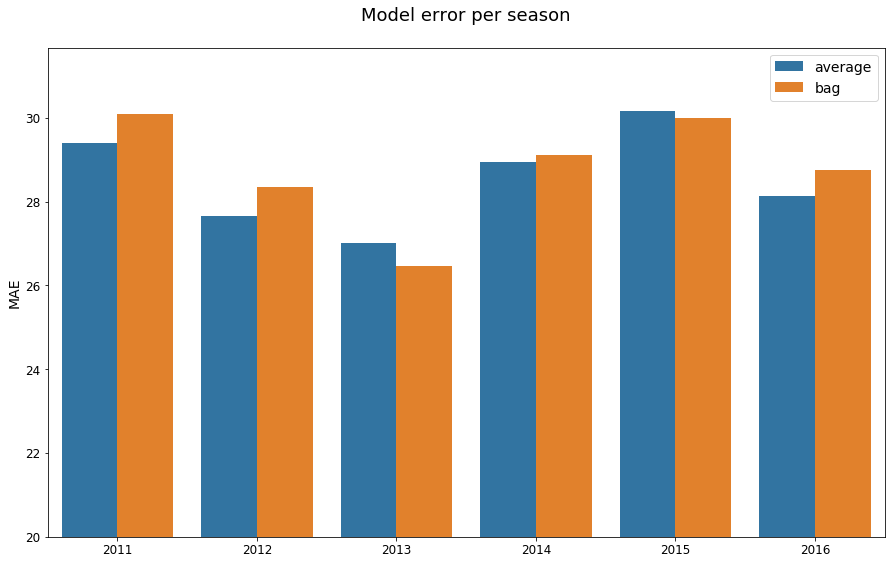

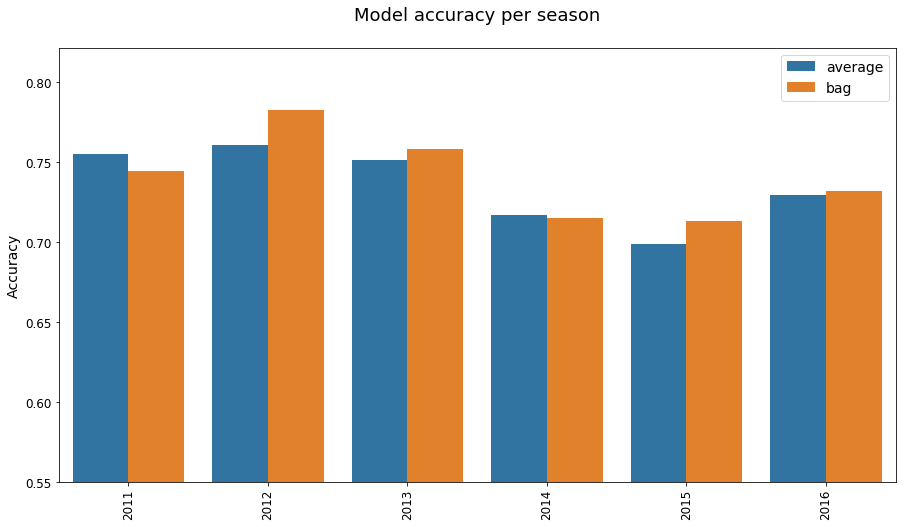

In [18]:
graph_yearly_model_performance(year_scores)

In [19]:
year_scores.groupby('model').mean()

,accuracy,error,year
model,,,
average,0.735511,28.551620,2013.5
bag,0.741069,28.796627,2013.5


### Averaging and bagging are about the same on a yearly basis as well
Bagging has a slightly higher accuracy, but a slightly higher error. Averaging "wins" 4 years on error, but bagging "wins" 4 years on accuracy. Given that bagging makes for a simpler model (fewer params, and don't have to worry about getting the weights right), I'll stick with that for now. I'll compare the two model structures more thoroughly after doing some more feature engineering.